# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Reading metadata

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000
1,1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,Yes,8250
2,2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000
3,3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500
4,4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850


In [3]:
df.nunique()

id              54273
brand              53
model            1827
model_year         34
milage           3212
fuel_type           7
engine           1061
transmission       46
ext_col           260
int_col           124
accident            2
clean_title         1
price            1481
dtype: int64

# Dropping unnecessary/multiple categorical columns

In [4]:
df = df.drop(['id', 'model', 'clean_title'], axis=1)
df = df.drop(['ext_col', 'int_col'], axis=1)

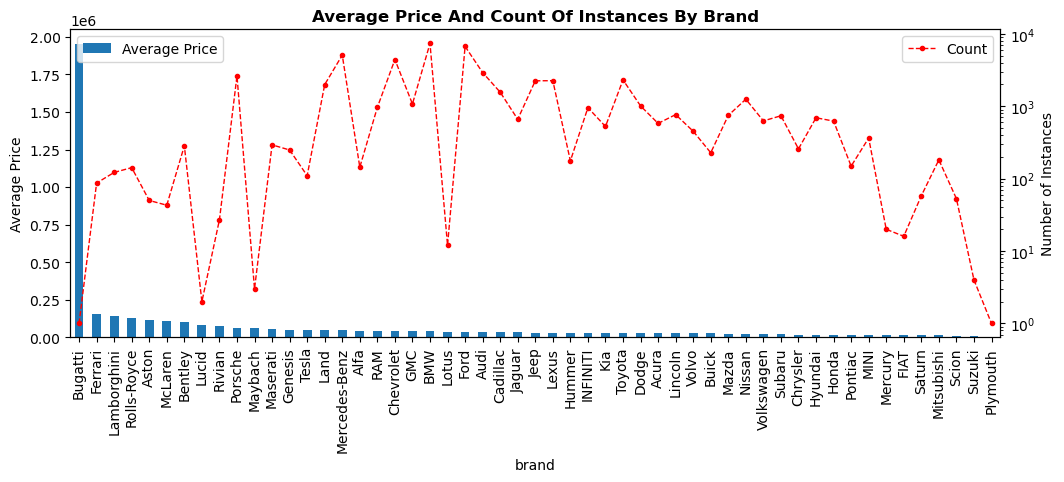

In [5]:
g = df.groupby('brand').agg({'price':['mean','count']}).sort_values(('price','mean'),ascending=False)

fig, ax = plt.subplots(figsize=(12,4))
ax2 = ax.twinx()

g.plot.bar(ax=ax, y=('price', 'mean'), label='Average Price')
g.plot.line(ax=ax2, y=('price', 'count'), ls = '--', lw = 1, color = 'red', marker = '.', label = 'Count')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_yscale('log')
ax.set_title('Average Price And Count Of Instances By Brand',fontweight='bold')
ax.set_ylabel('Average Price')
ax2.set_ylabel('Number of Instances')
plt.show()

In [6]:
df.loc[df['brand'] == 'Bugatti', 'brand'] = np.nan

# Categorizing fuel_type

In [7]:
df['fuel_type'] = df['fuel_type'].apply(lambda x: np.nan if str(x).strip() == '–' 
                                             else 'Electric' if str(x).strip() == 'not supported'
                                             else x)

# Categorizing transmission

In [8]:
df['transmission'] = df['transmission'].str.contains('A/T|Automatic',case=False).astype(str)

# Extracting two new features form 'engine' and dropping 'engine' 

In [9]:
df['HP'] = df['engine'].apply(lambda x: str(x).strip().split('HP')[0]).apply(pd.to_numeric, errors='coerce')
df['L'] = df['engine'].apply(lambda x: str(x).strip().split('HP ')[-1].split('L')[0]).apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)
df.drop('engine', axis=1, inplace=True)

# Checking the distribution of int/float data for outliers

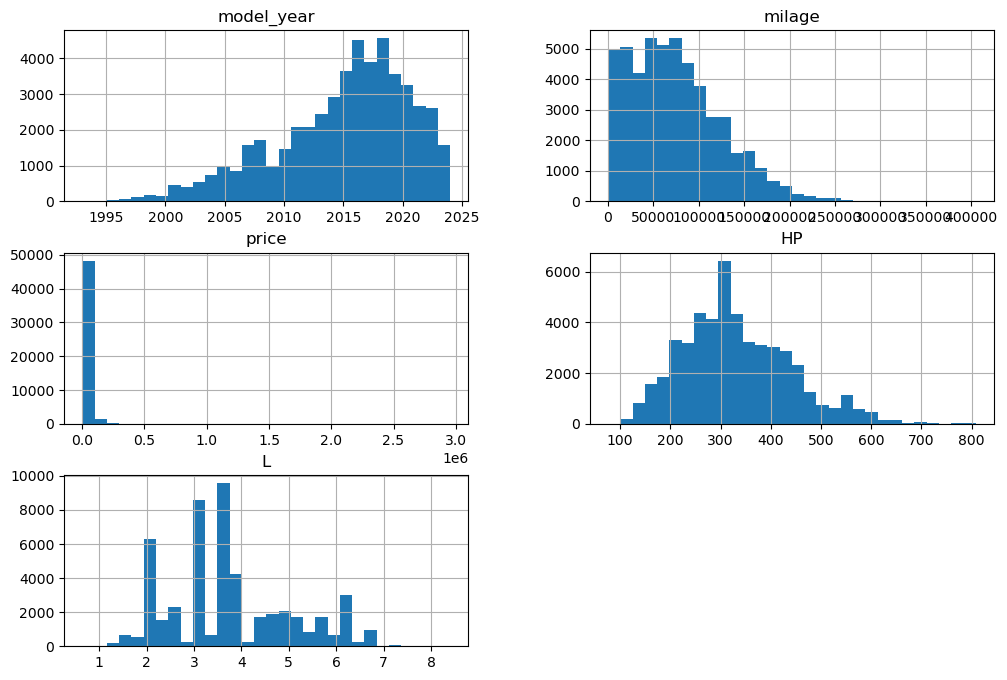

In [10]:
df.hist(figsize = (12,8), bins=30)
plt.xticks(rotation=90)
plt.show()

# Removing outliers

In [11]:
for column in df.drop('price', axis=1).select_dtypes([int,float]).columns:
    column_mean = df[column].mean()
    column_std = df[column].std()
    lower_bound = column_mean - 2*column_std
    upper_bound = column_mean + 2*column_std
    
    df=df[(df[column]<upper_bound)&(df[column]>lower_bound)]

# Creating dummies

In [12]:
for column in df.select_dtypes(object):
    dummies_df = pd.get_dummies(df[column], drop_first=True, prefix=column).astype(int)
    df = df.drop(column, axis=1)
    df = pd.concat([df, dummies_df], axis=1)

# Seperating features and labels

In [13]:
X=df.drop(columns='price')
y=df['price']

# Plotting error to get best number of sample size (XGBoost Regressor)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor 

estimator = XGBRegressor()

bounds = []
errors = []

for bound in range(500, len(X), 100):
    X=df.drop(columns='price')[:bound]
    y=df['price'][:bound]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    estimator.fit(X_train, y_train)
    pred = estimator.predict(X_test)
    error = mean_squared_error(y_test, pred)**0.5
    bounds.append(bound)
    errors.append(error)

<Axes: >

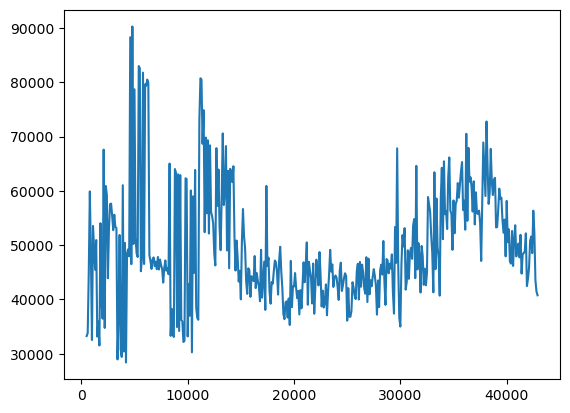

In [15]:
sns.lineplot(x=bounds[:], y=errors[:])

<Axes: >

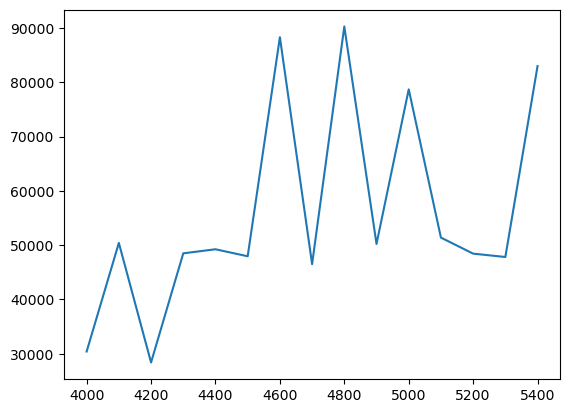

In [16]:
sns.lineplot(x=bounds[35:50], y=errors[35:50])

In [17]:
X=df.drop(columns='price')[:4200]
y=df['price'][:4200]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

estimator.fit(X_train, y_train)
pred = estimator.predict(X_test)
error = mean_squared_error(y_test, pred)**0.5

print(error)

28384.596465007395


# Getting the ideal values of parameters for XGBoost Regressor

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid={'n_estimators':[100,500,1000,2000],
            'max_depth':[3,5,8,10],
            'learning_rate':[0.01,0.05,0.1,0.15]}

grid_search_cv=GridSearchCV(estimator=XGBRegressor(),
                         param_grid=param_grid,
                         scoring='neg_root_mean_squared_error',
                         cv=3,
                         verbose=10)

grid_search_cv.fit(X_train,y_train)

best_model=grid_search_cv.best_estimator_
best_params = grid_search_cv.best_params_

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 1/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-56297.853 total time=   0.1s
[CV 2/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 2/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-41744.868 total time=   0.1s
[CV 3/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 3/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-28771.245 total time=   0.1s
[CV 1/3; 2/64] START learning_rate=0.01, max_depth=3, n_estimators=500..........
[CV 1/3; 2/64] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-54643.834 total time=   0.5s
[CV 2/3; 2/64] START learning_rate=0.01, max_depth=3, n_estimators=500..........
[CV 2/3; 2/64] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-41834.492 total time=   0.4

In [19]:
best_params

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}

# XGBoost Regressor

Mean absolute error: 13832.530741285624
Mean squared error: 479596456.10224605
Root mean squared error: 21899.690776407006


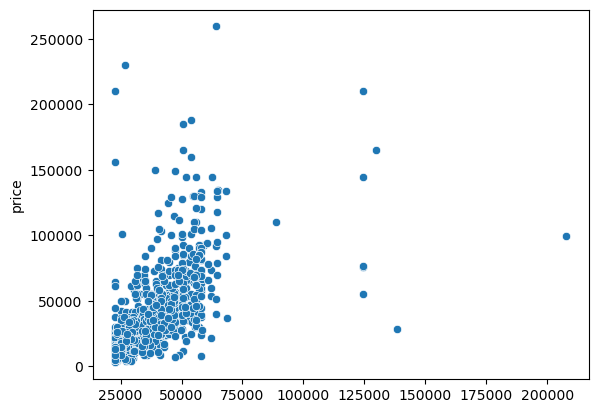

In [20]:
best_model.fit(X_train, y_train)
pred = best_model.predict(X_test)

from sklearn.metrics import mean_absolute_error

print('Mean absolute error:', mean_absolute_error(y_test, pred))
print('Mean squared error:', mean_squared_error(y_test, pred))
print('Root mean squared error:', mean_squared_error(y_test, pred)**0.5)

model_mae = mean_absolute_error(y_test, pred)
model_mse = mean_squared_error(y_test, pred)
model_rmse = mean_squared_error(y_test, pred)**0.5

model_errors = [model_mae, model_mse, model_rmse]

sns.scatterplot(x=pred, y=y_test)
plt.show()

# Predicted vs. Actual values

In [21]:
pred_vs_act = pd.concat([pd.Series(pred), y_test.reset_index(drop=True)], axis=1)
pred_vs_act.columns = ['pred', 'test']

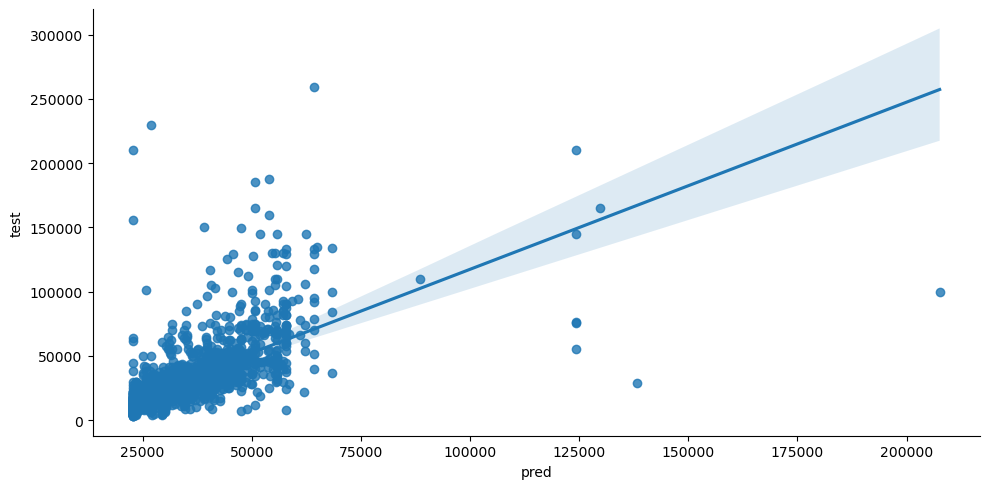

In [22]:
sns.lmplot(pred_vs_act, x='pred', y='test', aspect = 2)

# Implemention Deep Learning Neural Network

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Setting up the network

In [24]:
nn_model = Sequential()

nn_model.add(Dense(59, activation = 'relu'))
nn_model.add(Dropout(0.2))

nn_model.add(Dense(29, activation = 'relu'))
nn_model.add(Dropout(0.2))

nn_model.add(Dense(9, activation = 'relu'))
nn_model.add(Dropout(0.2))

nn_model.add(Dense(1))

nn_model.compile(optimizer='adam', loss='mse')

# Early Stopping

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 10, verbose = 10, mode = 'min')

# Training the model

In [26]:
nn_model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=600,verbose=1,
          callbacks=[early_stopping])

Epoch 1/600
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2455715328.0000 - val_loss: 1491494784.0000
Epoch 2/600
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2263747072.0000 - val_loss: 1480720640.0000
Epoch 3/600
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3084892416.0000 - val_loss: 1468614144.0000
Epoch 4/600
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2808264960.0000 - val_loss: 1440743552.0000
Epoch 5/600
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1960821376.0000 - val_loss: 1398296576.0000
Epoch 6/600
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2094370944.0000 - val_loss: 1353597696.0000
Epoch 7/600
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2193654528.0000 - val_loss: 1265773056.0000
Epoch 8/600
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2303536640.0000 - val_loss: 1132268928.0000
Epoch 9/600
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1646597504.0000 - val_loss: 903107200.0000
Epoch 10/600
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2524271104.00

# Plotting training vs validation losses

<Axes: >

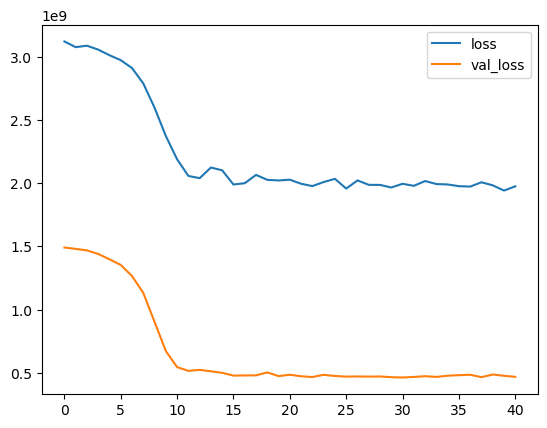

In [27]:
losses = pd.DataFrame(nn_model.history.history)
losses.plot()

# Predictions

In [104]:
predictions = nn_model.predict(X_test)

print('Mean absolute error:', mean_absolute_error(y_test, predictions))
print('Mean squared error:', mean_squared_error(y_test, predictions))
print('Root mean squared error:', mean_squared_error(y_test, predictions)**0.5)

nn_model_mae = mean_absolute_error(y_test, predictions)
nn_model_mse = mean_squared_error(y_test, predictions)
nn_model_rmse = mean_squared_error(y_test, predictions)**0.5

nn_model_errors = [nn_model_mae, nn_model_mse, nn_model_rmse]

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean absolute error: 12854.672070171582
Mean squared error: 468845176.6877919
Root mean squared error: 21652.83299450194


# Plotting predicted vs Actual values

In [105]:
pred_vs_act = pd.DataFrame(predictions, y_test).reset_index()
pred_vs_act['act'] = pred_vs_act['price']
pred_vs_act.drop('price', axis=1, inplace=True)
pred_vs_act.columns = ['pred', 'act']

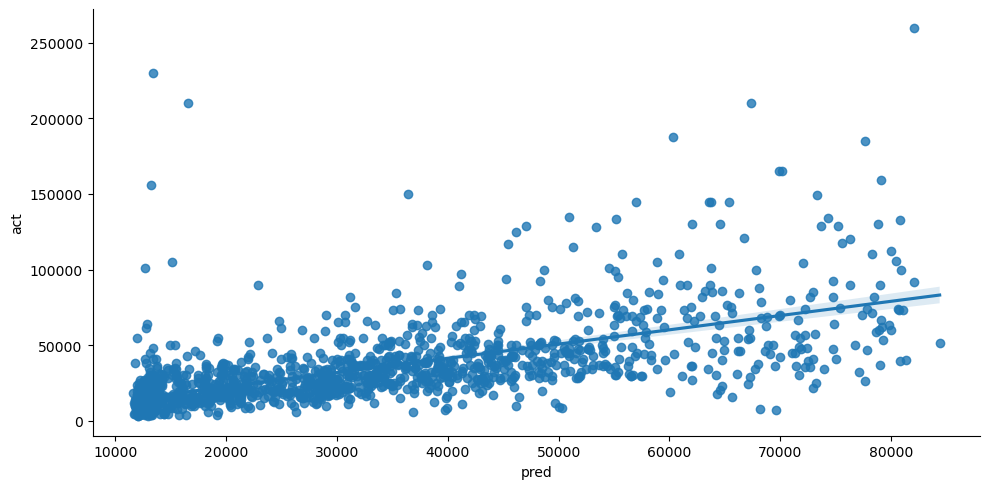

In [106]:
sns.lmplot(pred_vs_act, x='pred', y='act', aspect = 2)

# XGBoost Regressor vs Neural Network

In [107]:
errors_df = pd.DataFrame({'XGBoost' : model_errors, 'Neural Net' : nn_model_errors}, index=['mean absolute error', 'mean squared error', 'root mean squared error'])
errors_df

,XGBoost,Neural Net
mean absolute error,1.383253e+04,1.285467e+04
mean squared error,4.795965e+08,4.688452e+08
root mean squared error,2.189969e+04,2.165283e+04
